In [1]:
import matplotlib.pyplot as plt
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import pandas as pd
import pandas_profiling as pdp
import numpy as np
import os
import lightgbm as lgb

import math
import time
import datetime

# 複数のリストの直積（デカルト積）を生成するためのライブラリ
from itertools import product


#回帰の可視化
#関数の処理で必要なライブラリ
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer


from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)

import shap
# import xgboost

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

import warnings
warnings.filterwarnings('ignore')

# pillowをインポート
from PIL import Image
from matplotlib_venn import venn2, venn2_circles

from matplotlib import pyplot
%matplotlib inline

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

In [64]:
test = pd.read_csv('../inputs/test.csv')
test['商品ID'] = test['商品ID'].astype(str)
winner = pd.read_csv('./winner.csv',  header=None, names=['index', 'pred'])
answer = pd.read_csv('./answer.csv',  header=None, names=['index', 'true'])

In [65]:
test

,index,商品ID,店舗ID
0,0,1000001,0
1,1,1000001,1
2,2,1000001,2
3,3,1000001,3
4,4,1000001,4
...,...,...,...
3055,3055,3500001,13
3056,3056,3500001,14
3057,3057,3500001,15
3058,3058,3500001,16


In [66]:
winner

,index,pred
0,0,1.352254
1,1,0.947016
2,2,1.430261
3,3,6.229402
4,4,8.026325
...,...,...
3055,3055,2.340795
3056,3056,0.184904
3057,3057,0.222026
3058,3058,0.249282


In [67]:
answer

,index,true
0,0,0.0
1,1,0.0
2,2,0.0
3,3,3.0
4,4,7.0
...,...,...
3055,3055,2.0
3056,3056,0.0
3057,3057,0.0
3058,3058,0.0


In [68]:
final_df = pd.merge(test, answer, on='index', how='left')

In [69]:
final_df = pd.merge(final_df, winner, on='index', how='left')

In [70]:
final_df

,index,商品ID,店舗ID,true,pred
0,0,1000001,0,0.0,1.352254
1,1,1000001,1,0.0,0.947016
2,2,1000001,2,0.0,1.430261
3,3,1000001,3,3.0,6.229402
4,4,1000001,4,7.0,8.026325
...,...,...,...,...,...
3055,3055,3500001,13,2.0,2.340795
3056,3056,3500001,14,0.0,0.184904
3057,3057,3500001,15,0.0,0.222026
3058,3058,3500001,16,0.0,0.249282


In [115]:
final_df['予測との誤差'] = (final_df['true'] - final_df['pred'])**2
final_df['予測との誤差_ルート'] = np.sqrt((final_df['true'] - final_df['pred'])**2)
final_df['予測との誤差_true_1店舗'] = final_df['true'] / 18

final_df['予測との絶対値誤差'] = np.abs(final_df['true'] - final_df['pred'])
final_df['予測との絶対値誤差_1店舗'] = np.abs(final_df['true'] - final_df['pred']) / 18

final_df['予測との誤差_MAPE'] = np.abs(((final_df['true'] - final_df['pred']) / final_df['pred']))

In [122]:
final_df['予測との誤差_true_1店舗'].sum()

284.94444444444446

In [121]:
final_df['予測との絶対値誤差_1店舗'].sum()

197.361430068324

In [139]:
final_df['予測との誤差_true_1店舗'].sum() - final_df['予測との絶対値誤差_1店舗'].sum()

87.58301437612045

In [145]:
final_df['予測との誤差_true_1店舗'].sum()

284.94444444444446

In [146]:
87.58301437612045 / 284.94444444444446 * 100

30.736873830574535

In [143]:
( (final_df['予測との誤差_true_1店舗'].sum() - final_df['予測との絶対値誤差_1店舗'].sum()) / final_df['予測との誤差_true_1店舗'].sum() ) *100

30.736873830574535

In [127]:
final_df['予測との絶対値誤差_1店舗'].sum() / 170

1.1609495886372

In [137]:
#予測値と正解値を描写する関数
def True_Pred_map2(pred_df):
    RMSE = ((pred_df['予測との誤差_true_1店舗'].sum() - pred_df['予測との絶対値誤差_1店舗'].sum()) /pred_df['予測との誤差_true_1店舗'].sum()) *100
    R2 = pred_df['予測との絶対値誤差_1店舗'].sum() / 170
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    ax.scatter('true', 'pred', data=pred_df)
    ax.set_xlabel('実際の販売個数', fontsize=15)
    ax.set_ylabel('予測した販売個数', fontsize=15)
    ax.set_xlim(0-0.05 , 75+0.05)
    ax.set_ylim(0-0.05 , 75+0.05)
    x = np.linspace(0-0.05, 75+0.05)
    y = x
    ax.plot(x,y,'r-')
    plt.text(0.1, 0.9, '平均販売個数の誤差 [%] = {}'.format(str(round(RMSE, 5))), transform=ax.transAxes, fontsize=15)
    plt.text(0.1, 0.8, 'MAE = {}'.format(str(round(R2, 5))), transform=ax.transAxes, fontsize=15)

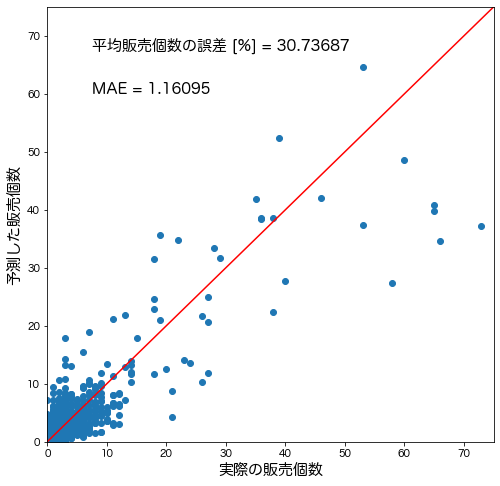

In [138]:
True_Pred_map2(final_df)

In [73]:
np.sqrt(final_df['予測との誤差'].mean())

2.2069958369991403

In [74]:
np.abs(final_df['予測との絶対値誤差'].sum() / final_df['true'].sum() - 100)

99.30736873830574

In [75]:
final_df['予測との絶対値誤差'].sum() / 18

197.361430068324

In [76]:
import numpy as np
np.sqrt(np.mean(((pred - true) / true)**2))*100

NameError: name 'pred' is not defined

In [77]:
#予測値と正解値を描写する関数
def True_Pred_map(pred_df):
    RMSE = np.sqrt(mean_squared_error(pred_df['true'], pred_df['pred']))
    R2 = r2_score(pred_df['true'], pred_df['pred'])
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    ax.scatter('true', 'pred', data=pred_df)
    ax.set_xlabel('実際の販売個数', fontsize=15)
    ax.set_ylabel('予測した販売個数', fontsize=15)
    ax.set_xlim(pred_df.min().min()-0.05 , pred_df.max().max()+0.05)
    ax.set_ylim(pred_df.min().min()-0.05 , pred_df.max().max()+0.05)
    x = np.linspace(pred_df.min().min()-0.05, pred_df.max().max()+0.05, 2)
    y = x
    ax.plot(x,y,'r-')
    plt.text(0.1, 0.9, 'RMSE = {}'.format(str(round(RMSE, 5))), transform=ax.transAxes, fontsize=15)
    plt.text(0.1, 0.8, 'R^2 = {}'.format(str(round(R2, 5))), transform=ax.transAxes, fontsize=15)

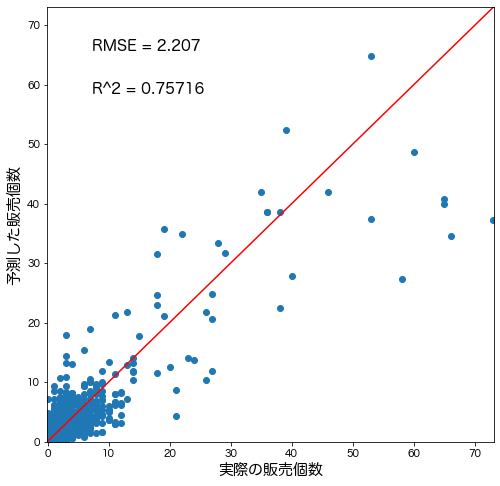

In [78]:
True_Pred_map(final_df[['true', 'pred']])

In [79]:
data = pd.read_pickle('../inputs/dataset_addfeature_lag_trend_clusters.pickle')
data = data[['店舗ID', '商品ID', '商品別_売上個数_クラスタ']]

In [80]:
data.head()

,店舗ID,商品ID,商品別_売上個数_クラスタ
0,0,1000001,6
1,0,1000002,6
2,0,1000003,1
3,0,1000004,10
4,0,1000005,6


In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1654632 entries, 0 to 1654631
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   店舗ID           1654632 non-null  object
 1   商品ID           1654632 non-null  object
 2   商品別_売上個数_クラスタ  1654632 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 50.5+ MB


In [82]:
final_df['商品ID'] = final_df['商品ID'].astype(str)
final_df['店舗ID'] = final_df['店舗ID'].astype(str)
final_df.head()

,index,商品ID,店舗ID,true,pred,予測との誤差,予測との誤差_ルート,予測との絶対値誤差,予測との誤差_MAPE
0,0,1000001,0,0.0,1.352254,1.828590,1.352254,1.352254,1.000000
1,1,1000001,1,0.0,0.947016,0.896840,0.947016,0.947016,1.000000
2,2,1000001,2,0.0,1.430261,2.045645,1.430261,1.430261,1.000000
3,3,1000001,3,3.0,6.229402,10.429037,3.229402,3.229402,0.518413
4,4,1000001,4,7.0,8.026325,1.053343,1.026325,1.026325,0.127870


In [83]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3060 entries, 0 to 3059
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        3060 non-null   int64  
 1   商品ID         3060 non-null   object 
 2   店舗ID         3060 non-null   object 
 3   true         3060 non-null   float64
 4   pred         3060 non-null   float64
 5   予測との誤差       3060 non-null   float64
 6   予測との誤差_ルート   3060 non-null   float64
 7   予測との絶対値誤差    3060 non-null   float64
 8   予測との誤差_MAPE  3054 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 239.1+ KB


In [84]:
final_df

,index,商品ID,店舗ID,true,pred,予測との誤差,予測との誤差_ルート,予測との絶対値誤差,予測との誤差_MAPE
0,0,1000001,0,0.0,1.352254,1.828590,1.352254,1.352254,1.000000
1,1,1000001,1,0.0,0.947016,0.896840,0.947016,0.947016,1.000000
2,2,1000001,2,0.0,1.430261,2.045645,1.430261,1.430261,1.000000
3,3,1000001,3,3.0,6.229402,10.429037,3.229402,3.229402,0.518413
4,4,1000001,4,7.0,8.026325,1.053343,1.026325,1.026325,0.127870
...,...,...,...,...,...,...,...,...,...
3055,3055,3500001,13,2.0,2.340795,0.116141,0.340795,0.340795,0.145590
3056,3056,3500001,14,0.0,0.184904,0.034189,0.184904,0.184904,1.000000
3057,3057,3500001,15,0.0,0.222026,0.049296,0.222026,0.222026,1.000000
3058,3058,3500001,16,0.0,0.249282,0.062142,0.249282,0.249282,1.000000


In [85]:
data

,店舗ID,商品ID,商品別_売上個数_クラスタ
0,0,1000001,6
1,0,1000002,6
2,0,1000003,1
3,0,1000004,10
4,0,1000005,6
...,...,...,...
1654627,13,3500001,10
1654628,14,3500001,10
1654629,15,3500001,10
1654630,16,3500001,10


In [86]:
comparison_df = pd.merge(final_df, data, on=['商品ID', '店舗ID'], how='left')
comparison_df = comparison_df[~comparison_df.duplicated()]

In [87]:
comparison_df

,index,商品ID,店舗ID,true,pred,予測との誤差,予測との誤差_ルート,予測との絶対値誤差,予測との誤差_MAPE,商品別_売上個数_クラスタ
0,0,1000001,0,0.0,1.352254,1.828590,1.352254,1.352254,1.000000,6
24,1,1000001,1,0.0,0.947016,0.896840,0.947016,0.947016,1.000000,6
48,2,1000001,2,0.0,1.430261,2.045645,1.430261,1.430261,1.000000,6
72,3,1000001,3,3.0,6.229402,10.429037,3.229402,3.229402,0.518413,6
96,4,1000001,4,7.0,8.026325,1.053343,1.026325,1.026325,0.127870,6
...,...,...,...,...,...,...,...,...,...,...
62880,3055,3500001,13,2.0,2.340795,0.116141,0.340795,0.340795,0.145590,10
62904,3056,3500001,14,0.0,0.184904,0.034189,0.184904,0.184904,1.000000,10
62928,3057,3500001,15,0.0,0.222026,0.049296,0.222026,0.222026,1.000000,10
62952,3058,3500001,16,0.0,0.249282,0.062142,0.249282,0.249282,1.000000,10


In [88]:
comparison_df['商品別_売上個数_クラスタ'].value_counts()

6     1116
1      594
10     414
0      324
4      180
3      162
2      108
5       54
8       54
7       36
9       18
Name: 商品別_売上個数_クラスタ, dtype: int64

In [89]:
comparison_df_0 = comparison_df[comparison_df['商品別_売上個数_クラスタ'] == 0]
comparison_df_0.head()

,index,商品ID,店舗ID,true,pred,予測との誤差,予測との誤差_ルート,予測との絶対値誤差,予測との誤差_MAPE,商品別_売上個数_クラスタ
5022,252,1002582,0,9.0,1.602990,54.715761,7.397010,7.397010,4.614509,0
5026,253,1002582,1,5.0,2.521963,6.140669,2.478037,2.478037,0.982583,0
5030,254,1002582,2,1.0,2.680786,2.825040,1.680786,1.680786,0.626975,0
5034,255,1002582,3,10.0,3.611161,40.817262,6.388839,6.388839,1.769192,0
5038,256,1002582,4,1.0,3.977636,8.866315,2.977636,2.977636,0.748594,0


In [90]:
comparison_df_0 = comparison_df_0.groupby(['商品ID'])[['true','pred','予測との誤差_ルート']].mean().reset_index()
comparison_df_0 = comparison_df_0.sort_values('予測との誤差_ルート', ascending=False)
comparison_df_0.head()

,商品ID,true,pred,予測との誤差_ルート
17,2900075,43.388889,40.130086,13.142822
4,1600003,14.666667,13.561762,5.176822
0,1002582,4.777778,3.241093,3.243910
6,1800003,4.722222,5.628863,2.024793
11,2400001,3.611111,2.763051,1.671814


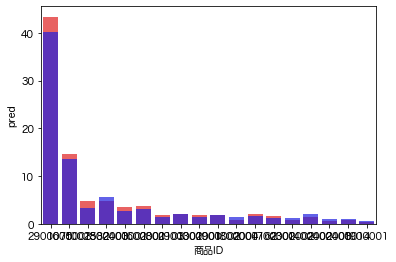

In [109]:
plt.subplot()
sns.barplot(x='商品ID', y='true', data=comparison_df_0[:30],color='red', alpha=0.7)
sns.barplot(x='商品ID', y='pred', data=comparison_df_0[:30],color='blue', alpha=0.7)
plt.show()

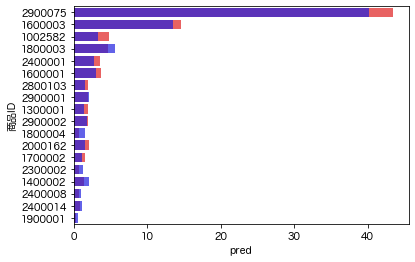

In [110]:
plt.subplot()
sns.barplot(x='true', y='商品ID', data=comparison_df_0[:30],color='red', alpha=0.7)
sns.barplot(x='pred', y='商品ID', data=comparison_df_0[:30],color='blue', alpha=0.7)
plt.show()

In [111]:
comparison_df_10 = comparison_df[comparison_df['商品別_売上個数_クラスタ'] == 10]
comparison_df_10.head()

,index,商品ID,店舗ID,true,pred,予測との誤差,予測との誤差_ルート,商品別_売上個数_クラスタ
1296,54,1000004,0,0.0,0.814198,0.662919,0.814198,10
1320,55,1000004,1,0.0,0.312999,0.097969,0.312999,10
1344,56,1000004,2,0.0,0.606280,0.367575,0.606280,10
1368,57,1000004,3,1.0,1.195245,0.038121,0.195245,10
1392,58,1000004,4,0.0,0.903641,0.816566,0.903641,10


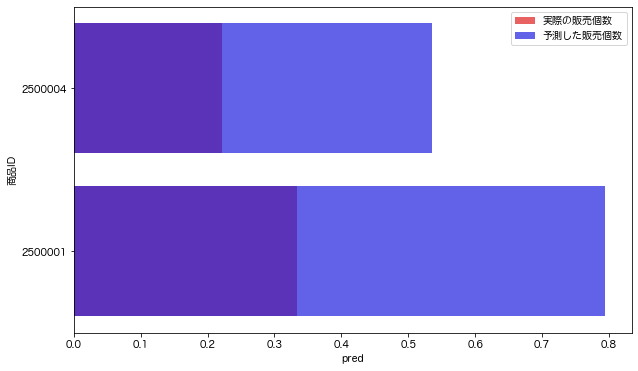

In [190]:
cluster = 7

comparison_df_ = comparison_df[comparison_df['商品別_売上個数_クラスタ'] == cluster]
comparison_df_ = comparison_df_.groupby(['商品ID'])[['true','pred','予測との誤差_ルート']].mean().reset_index()
comparison_df_ = comparison_df_.sort_values('予測との誤差_ルート', ascending=False)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
sns.barplot(x='true', y='商品ID', data=comparison_df_[:30],color='red', alpha=0.7, label='実際の販売個数')
sns.barplot(x='pred', y='商品ID', data=comparison_df_[:30],color='blue', alpha=0.7,  label='予測した販売個数')
ax.legend()

# 軸の範囲指定 
# X軸:xlim(開始, 終了) Y軸:ylim(開始, 終了)
# plt.xlim(0, 45)
# plt.ylim(0, 10)

plt.show()

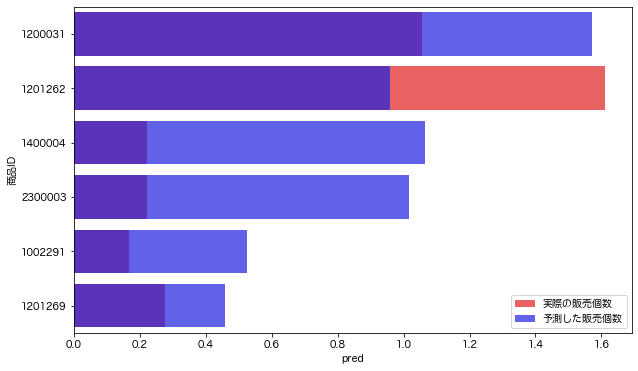

In [182]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
sns.barplot(x='true', y='商品ID', data=comparison_df_[:30],color='red', alpha=0.7, label='実際の販売個数')
sns.barplot(x='pred', y='商品ID', data=comparison_df_[:30],color='blue', alpha=0.7,  label='予測した販売個数')
ax.legend()

# 軸の範囲指定 
# X軸:xlim(開始, 終了) Y軸:ylim(開始, 終了)
# plt.xlim(0, 45)
# plt.ylim(0, 10)

plt.show()

In [91]:
sales_history_df = pd.read_pickle('../inputs/train_merged_data_pre.pickle')

In [92]:
sales_history_df2018 = sales_history_df[(sales_history_df['日付'] >= '2018-01-01') & (sales_history_df['日付'] <= '2018-12-31')]
sales_history_df2019 = sales_history_df[sales_history_df['日付'] > '2018-12-31']

In [93]:
len(sales_history_df)

1117298

In [94]:
len(sales_history_df2018)

685693

In [95]:
len(sales_history_df2019)

431605

In [96]:
sales_history_df2018.商品ID.unique()

array(['1000001', '1000017', '1000018', ..., '2900065', '3300251',
       '3300252'], dtype=object)

In [97]:
sales_history_df2019.商品ID.unique()

array(['1000003', '1000006', '1000009', ..., '1700230', '2100176',
       '2400101'], dtype=object)

In [99]:
test.商品ID

0       1000001
1       1000001
2       1000001
3       1000001
4       1000001
         ...   
3055    3500001
3056    3500001
3057    3500001
3058    3500001
3059    3500001
Name: 商品ID, Length: 3060, dtype: object

In [105]:
len(test.商品ID.unique())

170

In [102]:
item_id2018 = set(test.商品ID.unique()) & set(sales_history_df2018.商品ID.unique())
item_id2018

{'1000001',
 '1000002',
 '1000003',
 '1000004',
 '1000005',
 '1000006',
 '1000007',
 '1000008',
 '1000009',
 '1000010',
 '1000011',
 '1100001',
 '1100002',
 '1200001',
 '1200002',
 '1200003',
 '1200004',
 '1200005',
 '1200006',
 '1200007',
 '1200008',
 '1200009',
 '1200010',
 '1200011',
 '1200012',
 '1200013',
 '1200014',
 '1200015',
 '1200016',
 '1200017',
 '1200018',
 '1200019',
 '1200020',
 '1200021',
 '1200022',
 '1200023',
 '1200024',
 '1200025',
 '1200026',
 '1200027',
 '1200028',
 '1200029',
 '1200030',
 '1200031',
 '1200032',
 '1200033',
 '1200034',
 '1200035',
 '1200036',
 '1200037',
 '1200038',
 '1200039',
 '1200040',
 '1300001',
 '1300002',
 '1400001',
 '1400002',
 '1400003',
 '1400004',
 '1500001',
 '1600001',
 '1600002',
 '1600003',
 '1700001',
 '1700002',
 '1700003',
 '1700004',
 '1700005',
 '1700006',
 '1700007',
 '1700008',
 '1700009',
 '1700010',
 '1700011',
 '1700012',
 '1700013',
 '1700014',
 '1700015',
 '1700016',
 '1700017',
 '1700018',
 '1700019',
 '1800001',
 '18

In [106]:
len(item_id2018)

150

In [107]:
item_id2019 = set(test.商品ID.unique()) - item_id2018
item_id2019

{'1002291',
 '1002377',
 '1002503',
 '1002582',
 '1201262',
 '1201269',
 '1400898',
 '1600052',
 '1600054',
 '1800179',
 '2000162',
 '2100152',
 '2400088',
 '2500229',
 '2500230',
 '2800090',
 '2800101',
 '2800103',
 '2900075',
 '3200026'}

In [108]:
len(item_id2019)

20